<a href="https://colab.research.google.com/github/vasubansal1033/udemy-selfDriving-car/blob/master/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/vasubansal1033/Track/

fatal: destination path 'Track' already exists and is not an empty directory.


In [0]:
!ls Track

driving_log.csv  IMG  README.md


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
import cv2
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
from imgaug import augmenters as iaa

In [0]:
import os
import ntpath
from sklearn.utils import shuffle

In [0]:
import matplotlib.image as mpimg

In [0]:
datadir = 'Track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/center_2019_04_11_12_22_02_880.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/left_2019_04_11_12_22_02_880.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/right_2019_04_11_12_22_02_880.jpg,0.0,0.0,0,0.000080
1,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/center_2019_04_11_12_22_02_981.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/left_2019_04_11_12_22_02_981.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/right_2019_04_11_12_22_02_981.jpg,0.0,0.0,0,0.000079
2,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/center_2019_04_11_12_22_03_093.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/left_2019_04_11_12_22_03_093.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/right_2019_04_11_12_22_03_093.jpg,0.0,0.0,0,0.000079
3,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/center_2019_04_11_12_22_03_209.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/left_2019_04_11_12_22_03_209.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/right_2019_04_11_12_22_03_209.jpg,0.0,0.0,0,0.000078
4,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/center_2019_04_11_12_22_03_313.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/left_2019_04_11_12_22_03_313.jpg,/Users/seanxu/Desktop/Learn/Python/Spyder_py3/Udemy/Self_Driving_Cars/9_Self-Driving_Cars_Behavioural_Cloning/data/IMG/right_2019_04_11_12_22_03_313.jpg,0.0,0.0,0,0.000078


In [0]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_04_11_12_22_02_880.jpg,left_2019_04_11_12_22_02_880.jpg,right_2019_04_11_12_22_02_880.jpg,0.0,0.0,0,0.000080
1,center_2019_04_11_12_22_02_981.jpg,left_2019_04_11_12_22_02_981.jpg,right_2019_04_11_12_22_02_981.jpg,0.0,0.0,0,0.000079
2,center_2019_04_11_12_22_03_093.jpg,left_2019_04_11_12_22_03_093.jpg,right_2019_04_11_12_22_03_093.jpg,0.0,0.0,0,0.000079
3,center_2019_04_11_12_22_03_209.jpg,left_2019_04_11_12_22_03_209.jpg,right_2019_04_11_12_22_03_209.jpg,0.0,0.0,0,0.000078
4,center_2019_04_11_12_22_03_313.jpg,left_2019_04_11_12_22_03_313.jpg,right_2019_04_11_12_22_03_313.jpg,0.0,0.0,0,0.000078


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


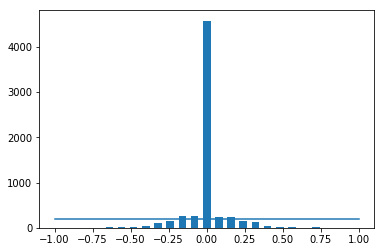

In [0]:
num_bins = 25 
samples_per_bin = 200
hist, bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:])*0.5
print(bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

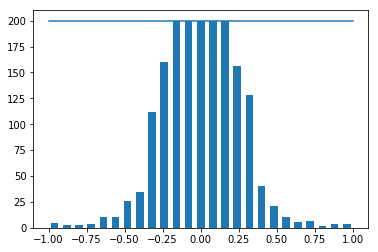

In [0]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
data.drop(data.index[remove_list],inplace = True)
  
hist,_ = np.histogram(data['steering'],(num_bins))
  
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [0]:
print(data.iloc[1])
def load_img_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steering

image_paths, steerings = load_img_steering(datadir + '/IMG',data)

center      center_2019_04_11_12_22_05_009.jpg
left        left_2019_04_11_12_22_05_009.jpg  
right       right_2019_04_11_12_22_05_009.jpg 
steering   -0.0998579                         
throttle    1                                 
reverse     0                                 
speed       6.81972                           
Name: 20, dtype: object


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train,X_valid,y_train,y_valid = train_test_split(image_paths,steerings,test_size=0.2)

In [0]:
print('Training samples : {}\nValid samples : {}'.format(len(X_train),len(X_valid)))

Training samples : 1396
Valid samples : 350


Text(0.5, 1.0, 'Validation set')

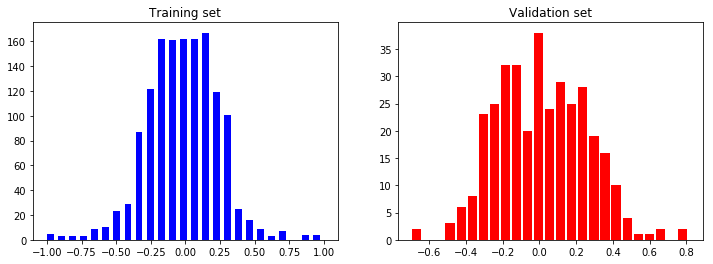

In [0]:
fig,axes = plt.subplots(1,2, figsize =(12,4))
axes[0].hist(y_train, bins = num_bins,width = 0.05, color ='blue')
axes[0].set_title('Training set')


axes[1].hist(y_valid, bins = num_bins,width = 0.05, color ='red')
axes[1].set_title('Validation set')


In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent = {'x':(-0.1,0.1),'y':(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1) # horizontal flip
  steering_angle = -steering_angle
  return image,steering_angle



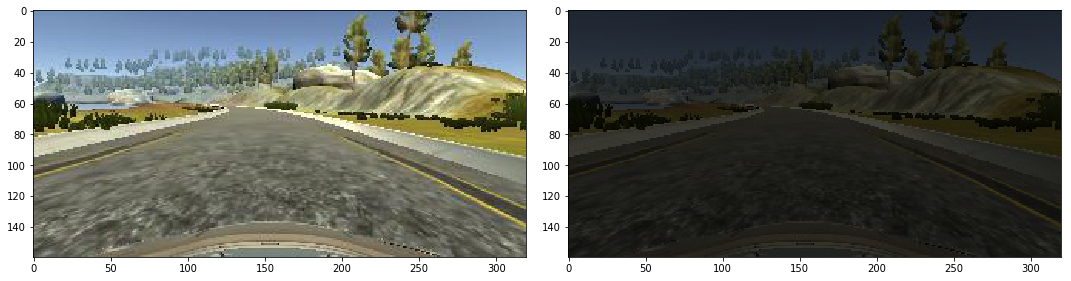

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[1].imshow(zoomed_image)

In [0]:
def random_augment(image , steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() <0.5:
    image = pan(image)
  if np.random.rand() <0.5:
    image = zoom(image)
  if np.random.rand() <0.5:
    image = img_random_brightness(image)
  if np.random.rand() <0.5:
    image, steering_angle = img_random_flip(image,steering_angle)
  return image,steering_angle

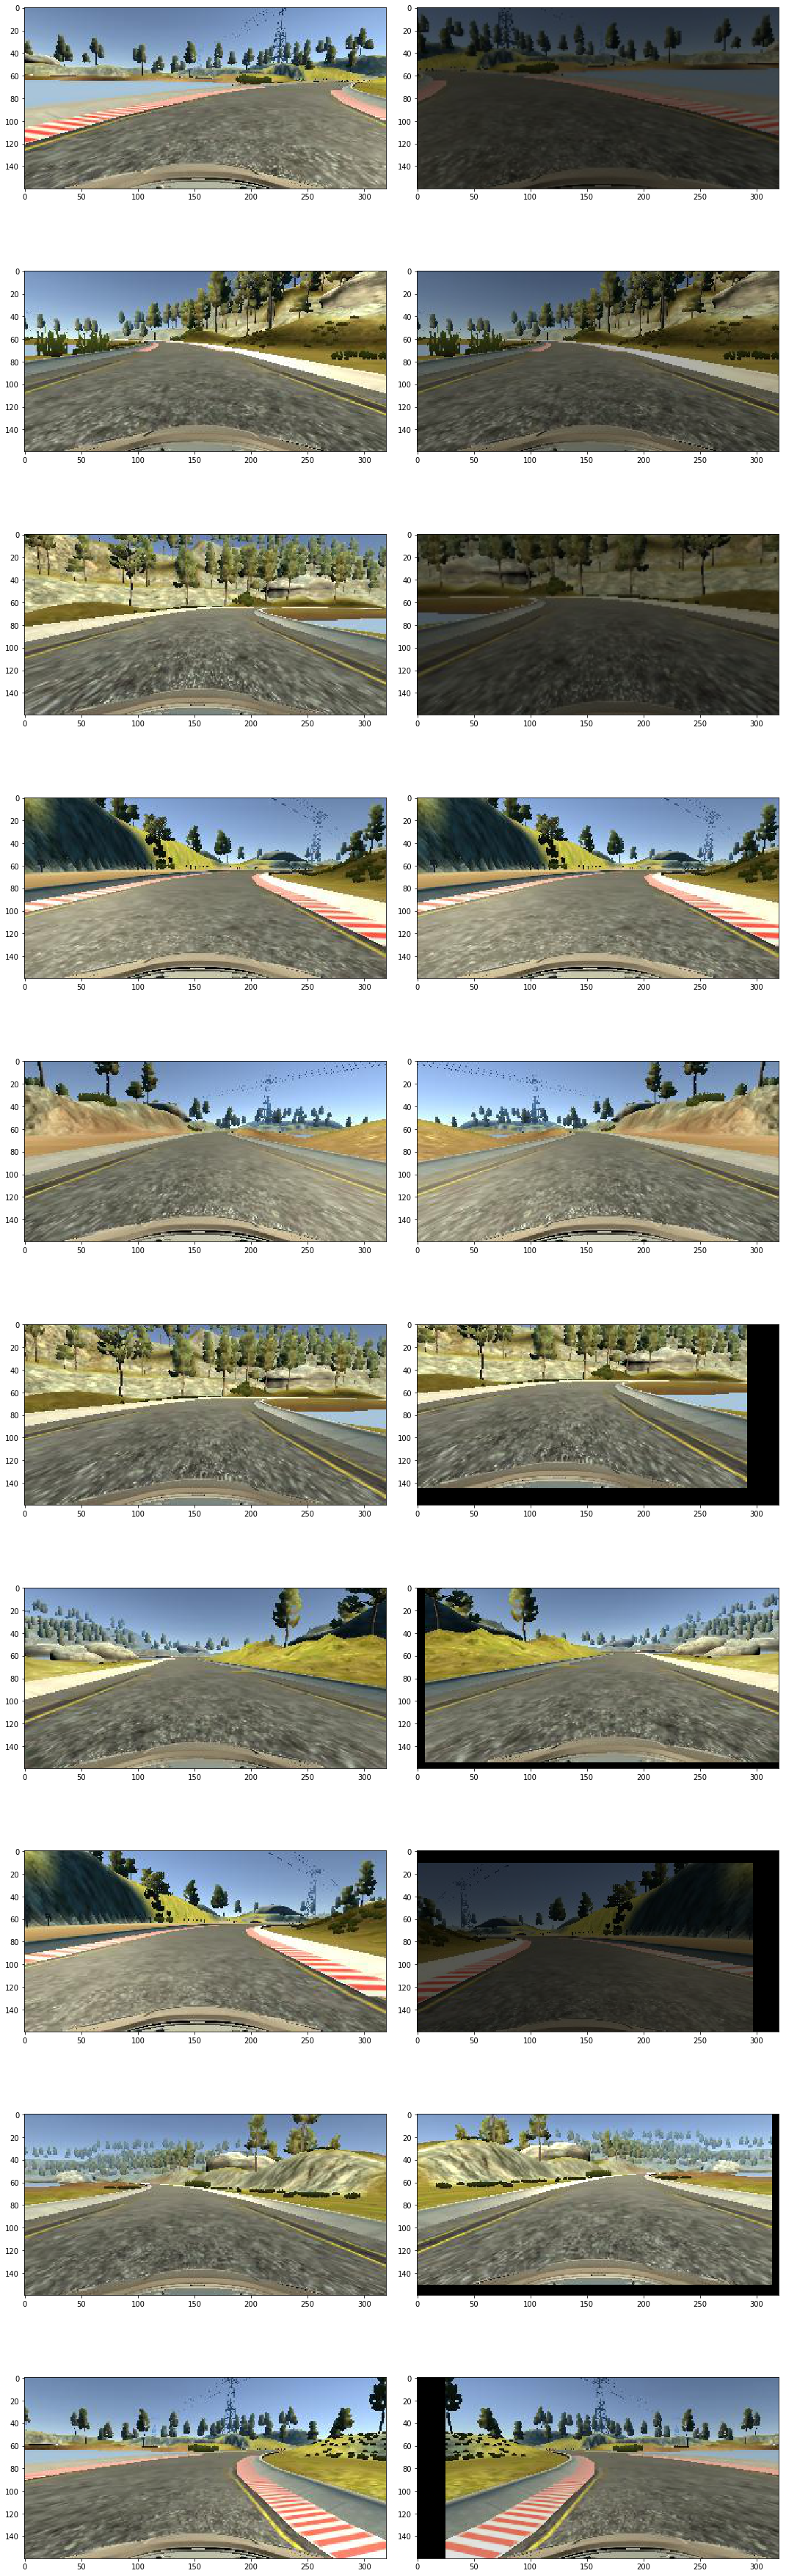

In [0]:
ncol = 2
nrow = 10
fig,axs = plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0,len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image,random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][1].imshow(augmented_image)

In [0]:
def img_preprocess(img):
  #img = mpimg.imread(img)
  img = img[60:140,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  cv2.GaussianBlur(img,(3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

In [0]:
# image = image_paths[100]
# original_image = mpimg.imread(image)
# preprocessed_image = img_preprocess(image)

# fig,axes = plt.subplots(1,2,figsize=(15,10))
# fig.tight_layout()
# axes[0].imshow(original_image)
# axes[0].set_title('Original Image')

# axes[1].imshow(preprocessed_image)
# axes[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering =[]
    
    for i in range(batch_size):
      random_index = random.randint(0,len(image_paths)-1)
      if istraining:
        im,steering = random_augment(image_paths[random_index],steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
      
    yield (np.asarray(batch_img),np.asarray(batch_steering))

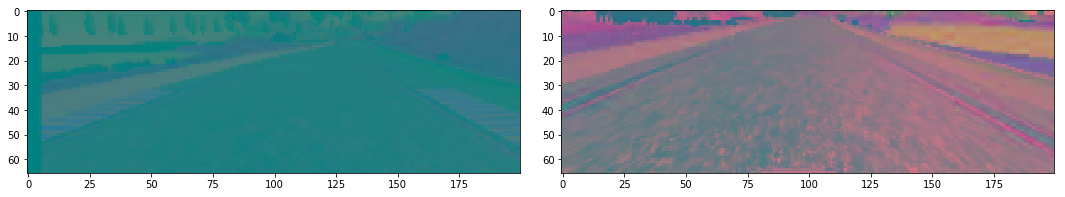

In [0]:
x_train_gen,y_train_gen = next(batch_generator(X_train,y_train,1,1))
x_valid_gen,y_valid_gen = next(batch_generator(X_valid,y_valid,1,0))


fig, axs = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[1].imshow(x_valid_gen[0])

In [0]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))


In [0]:
# plt.imshow(X_valid[random.randint(0, len(X_valid))])
# plt.axis('off')
# print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,5,5,subsample = (2,2), input_shape = (66,200,3),activation = 'elu'))
  model.add(Convolution2D(36,5,5,subsample = (2,2),activation = 'elu'))
  model.add(Convolution2D(48,5,5,subsample = (2,2),activation = 'elu'))
  model.add(Convolution2D(64,3,3,activation = 'elu'))
  model.add(Convolution2D(64,3,3,activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100,activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50,activation = 'elu'))
#   model.add(Dropout(0.5))
  model.add(Dense(10,activation= 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=0.001)
  model.compile(loss = 'mse',optimizer=optimizer)
  
  return model

In [0]:
model = nvidia_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [0]:
h = model.fit_generator(batch_generator(X_train,y_train,100,1),steps_per_epoch = 300,epochs = 10,validation_data = batch_generator(X_train,y_train,100,0),validation_steps=200,verbose=1,shuffle=1)
                        
                        #epochs = 30, validation_data = (X_valid,y_valid),batch_size = 100,verbose = 1,shuffle = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
300/300 [==============================] - 137s 456ms/step - loss: 0.0714 - val_loss: 0.0382
Epoch 2/10
300/300 [==============================] - 131s 437ms/step - loss: 0.0444 - val_loss: 0.0318
Epoch 3/10
300/300 [==============================] - 130s 433ms/step - loss: 0.0395 - val_loss: 0.0276
Epoch 4/10
300/300 [==============================] - 129s 430ms/step - loss: 0.0357 - val_loss: 0.0242
Epoch 5/10
300/300 [==============================] - 129s 430ms/step - loss: 0.0336 - val_loss: 0.0242
Epoch 6/10
300/300 [==============================] - 129s 432ms/step - loss: 0.0325 - val_loss: 0.0232
Epoch 7/10
300/300 [==============================] - 131s 436ms/step - loss: 0.0315 - val_loss: 0.0212
Epoch 8/10
300/300 [==============================] - 130s 435ms/step - loss: 0.0290 - val_loss: 0.0202
Epoch 9/10
300/300 [==============================] - 131s 435ms/step - loss: 0.0294 - val_loss: 0.0181
Epoch 10/10
300/

Text(0.5, 0, 'Epoch')

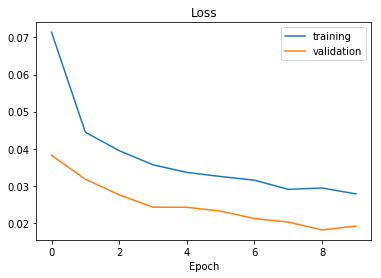

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [0]:
model.save('model.h5')

In [0]:

from google.colab import files
files.download('model.h5')